In [355]:
library(dlnm)
library(mgcv)
#library(dlmtree)
library(data.table)
library(plotly)
library(ggplot2)
library(parallel)
library(doParallel)
library(foreach)
library(coda)
library(lubridate)
library(xts)
library(timetk)
library(forecast)
library(gridExtra)
library(tidyr)
library(dplyr)
library(Hmisc)
library(xtable)
library(splines)
library(gnm)
library(Epi) 

In [356]:
environment <- read.csv("/Users/gabrielazemencikova/Desktop/ami-catalonia/project/card_var_pol_stat_data_at.csv")
colnames(environment)[1:18] = c('at_code','date','max_hum','min_hum','max_temp','min_temp','events','a_rolling_week','expected','a_asir_90','b_asir_365','pop_value','daily_diff_temp','daily_diff_hum','maximum_temperature_change','minimum_temperature_change','maximum_relative_humidity_change','minimum_relative_humidity_change')

# AT01, AT03,  NOT GOOD DATA for pollution - AT06, maybe(AT08) 
at_code = 'AT01'
environment_at <- environment[environment$at_code== at_code,]
#environment_at <- environment
#colnames(environment_at)

#======== CLIMATE ========
frequency = 30
environment_at['date'] <- lapply(environment_at['date'], ymd)

climate.max_temp <- subset(environment_at, select = c(date, max_temp))
climate.min_temp <- subset(environment_at, select = c(date, min_temp))
climate.max_hum <- subset(environment_at, select = c(date, max_hum))
climate.min_hum <- subset(environment_at, select = c(date, min_hum))
climate.max_PM10 <- subset(environment_at, select = c(date, max_PM10))
climate.max_O3 <- subset(environment_at, select = c(date, max_O3))


#convert temperature and rainfall data frames to xts objects for use in time series plotting.
climate.max_temp = as.xts(climate.max_temp[,-1,drop = FALSE], order.by = as.Date(climate.max_temp[,1]))
climate.min_temp = as.xts(climate.min_temp[,-1,drop = FALSE], order.by = as.Date(climate.min_temp[,1]))
climate.max_hum = as.xts(climate.max_hum[,-1,drop = FALSE], order.by = as.Date(climate.max_hum[,1]))
climate.min_hum = as.xts(climate.min_hum[,-1,drop = FALSE], order.by = as.Date(climate.min_hum[,1]))
climate.max_PM10 = as.xts(climate.max_PM10[,-1,drop = FALSE], order.by = as.Date(climate.max_PM10[,1]))
climate.max_O3 = as.xts(climate.max_O3[,-1,drop = FALSE], order.by = as.Date(climate.max_O3[,1]))

## Monthly Development - environment data

In [357]:
# MAX TEMP
climate.max_temp <- apply.monthly(climate.max_temp, FUN = colMeans, na.rm = TRUE)
climate.max_temp <-tk_tbl(climate.max_temp, preserve_index = TRUE, rename_index = "date") 
climate.max_temp.ts <- ts(na.omit(climate.max_temp$max_temp), frequency = frequency)
trend_n <-tk_tbl(seasadj(mstl(climate.max_temp.ts)), preserve_index = FALSE) #additive series
climate.max_temp$temperature_sea <- trend_n$value #seasonally-adjusted temperature: trend+remainder
climate.max_temp$temperature_sea[climate.max_temp$temperature_sea < 0] <- 0
setnames(climate.max_temp, old="max_temp", new="temperature_obs")
trend_n <- tk_tbl(mstl(climate.max_temp.ts))
climate.max_temp$temp_tre <- trend_n$Trend #trend of cases: trend-only

climate.max_temp.spin <- subset(climate.max_temp, year(climate.max_temp$date)>=2010, select=c(date,temperature_obs)) 
climate.max_temp.spin$month <- month(climate.max_temp.spin$date)
climate.max_temp.spin$year <- year(climate.max_temp.spin$date)
climate.max_temp.spin$date <- NULL
climate.max_temp.spin <- spread(climate.max_temp.spin, year, temperature_obs)
climate.max_temp.spin <- as.matrix(climate.max_temp.spin)[,-1]
YMD1 <- plot_ly(x = c(2010,2011,2012,2013,2014,2015,2016,2017,2018), y = c("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"), z = ~climate.max_temp.spin, type = "contour", colorscale = 'heatmap', contours = list(showlabels = TRUE)) %>% colorbar(title = "Maximum Temperature (\u00B0C)", y = - 0.15,  # Adjust the position of the color bar below the plot
    len = 0.6,  # Adjust the length of the color bar
    xanchor = "right",
    orientation = "h",  # Set the orientation to horizontal
    x = 0.6,  # Align the color bar to the center
    titlefont = list(size = 13),
    thickness = 20  
  ) %>% layout(title="", xaxis=list(title ="Year"), yaxis=list(title="Month"), font=list(size = 13),height = 600, width = 800)

# MIN TEMP
climate.min_temp <- apply.monthly(climate.min_temp, FUN = colMeans, na.rm = TRUE)
climate.min_temp <-tk_tbl(climate.min_temp, preserve_index = TRUE, rename_index = "date") 
climate.min_temp.ts <- ts(na.omit(climate.min_temp$min_temp), frequency = frequency)
trend_n <-tk_tbl(seasadj(mstl(climate.min_temp.ts)), preserve_index = FALSE) #additive series
climate.min_temp$temperature_sea <- trend_n$value #seasonally-adjusted temperature: trend+remainder
climate.min_temp$temperature_sea[climate.min_temp$temperature_sea < 0] <- 0
setnames(climate.min_temp, old="min_temp", new="temperature_obs")
trend_n <- tk_tbl(mstl(climate.min_temp.ts))
climate.min_temp$temp_tre <- trend_n$Trend #trend of cases: trend-only

climate.min_temp.spin <- subset(climate.min_temp, year(climate.min_temp$date)>=2010, select=c(date,temperature_obs)) 
climate.min_temp.spin$month <- month(climate.min_temp.spin$date)
climate.min_temp.spin$year <- year(climate.min_temp.spin$date)
climate.min_temp.spin$date <- NULL
climate.min_temp.spin <- spread(climate.min_temp.spin, year, temperature_obs)
climate.min_temp.spin <- as.matrix(climate.min_temp.spin)[,-1]
YMD2 <- plot_ly(x = c(2010,2011,2012,2013,2014,2015,2016,2017,2018), y = c("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"), z = ~climate.min_temp.spin, type = "contour", colorscale = 'heatmap', contours = list(showlabels = TRUE)) %>% colorbar(title = "Minimum Temperature (\u00B0C)", y = - 0.15,  # Adjust the position of the color bar below the plot
    len = 0.6,  # Adjust the length of the color bar
    xanchor = "right",
    orientation = "h",  # Set the orientation to horizontal
    x = 0.6,  # Align the color bar to the center
    titlefont = list(size = 13),
    thickness = 20  
  ) %>% layout(title="", xaxis=list(title ="Year"), yaxis=list(title="Month"), font=list(size = 13),height = 600, width = 800)

# MAX HUM
climate.max_hum <- apply.monthly(climate.max_hum, FUN = colMeans, na.rm = TRUE)
climate.max_hum <-tk_tbl(climate.max_hum, preserve_index = TRUE, rename_index = "date") 
climate.max_hum.ts <- ts(na.omit(climate.max_hum$max_hum), frequency = frequency)
trend_n <-tk_tbl(seasadj(mstl(climate.max_hum.ts)), preserve_index = FALSE) #additive series
climate.max_hum$temperature_sea <- trend_n$value #seasonally-adjusted temperature: trend+remainder
climate.max_hum$temperature_sea[climate.max_hum$temperature_sea < 0] <- 0
setnames(climate.max_hum, old="max_hum", new="temperature_obs")
trend_n <- tk_tbl(mstl(climate.max_hum.ts))
climate.max_hum$temp_tre <- trend_n$Trend #trend of cases: trend-only

climate.max_hum.spin <- subset(climate.max_hum, year(climate.max_hum$date)>=2010, select=c(date,temperature_obs)) 
climate.max_hum.spin$month <- month(climate.max_hum.spin$date)
climate.max_hum.spin$year <- year(climate.max_hum.spin$date)
climate.max_hum.spin$date <- NULL
climate.max_hum.spin <- spread(climate.max_hum.spin, year, temperature_obs)
climate.max_hum.spin <- as.matrix(climate.max_hum.spin)[,-1]
YMD3 <- plot_ly(x = c(2010,2011,2012,2013,2014,2015,2016,2017,2018), y = c("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"), z = ~climate.max_hum.spin, type = "contour", colorscale = 'heatmap', contours = list(showlabels = TRUE)) %>% colorbar(title = "Maximum Humidity (%)", y = - 0.15,  # Adjust the position of the color bar below the plot
    len = 0.6,  # Adjust the length of the color bar
    xanchor = "right",
    orientation = "h",  # Set the orientation to horizontal
    x = 0.6,  # Align the color bar to the center
    titlefont = list(size = 13),
    thickness = 20  
  ) %>% layout(title="", xaxis=list(title ="Year"), yaxis=list(title="Month"), font=list(size = 13),height = 600, width = 800)

# MIN HUM
climate.min_hum <- apply.monthly(climate.min_hum, FUN = colMeans, na.rm = TRUE)
climate.min_hum <-tk_tbl(climate.min_hum, preserve_index = TRUE, rename_index = "date") 
climate.min_hum.ts <- ts(na.omit(climate.min_hum$min_hum), frequency = frequency)
trend_n <-tk_tbl(seasadj(mstl(climate.min_hum.ts)), preserve_index = FALSE) #additive series
climate.min_hum$temperature_sea <- trend_n$value #seasonally-adjusted temperature: trend+remainder
climate.min_hum$temperature_sea[climate.min_hum$temperature_sea < 0] <- 0
setnames(climate.min_hum, old="min_hum", new="temperature_obs")
trend_n <- tk_tbl(mstl(climate.min_hum.ts))
climate.min_hum$temp_tre <- trend_n$Trend #trend of cases: trend-only

climate.min_hum.spin <- subset(climate.min_hum, year(climate.min_hum$date)>=2010, select=c(date,temperature_obs)) 
climate.min_hum.spin$month <- month(climate.min_hum.spin$date)
climate.min_hum.spin$year <- year(climate.min_hum.spin$date)
climate.min_hum.spin$date <- NULL
climate.min_hum.spin <- spread(climate.min_hum.spin, year, temperature_obs)
climate.min_hum.spin <- as.matrix(climate.min_hum.spin)[,-1]
YMD4 <- plot_ly(x = c(2010,2011,2012,2013,2014,2015,2016,2017,2018), y = c("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"), z = ~climate.min_hum.spin, type = "contour", colorscale = 'heatmap', contours = list(showlabels = TRUE)) %>% colorbar(title = "Minimum Humidity (%)",y = - 0.15,  # Adjust the position of the color bar below the plot
    len = 0.6,  # Adjust the length of the color bar
    xanchor = "right",
    orientation = "h",  # Set the orientation to horizontal
    x = 0.6,  # Align the color bar to the center
    titlefont = list(size = 13),
    thickness = 20  
  ) %>% layout(title="", xaxis=list(title ="Year"), yaxis=list(title="Month"), font=list(size = 13),height = 600, width = 800)

# MAX PM10 
climate.max_PM10 <- apply.monthly(climate.max_PM10, FUN = colMeans, na.rm = TRUE)
climate.max_PM10 <-tk_tbl(climate.max_PM10, preserve_index = TRUE, rename_index = "date") 
climate.max_PM10.ts <- ts(na.omit(climate.max_PM10$max_PM10), frequency = frequency)
trend_n <-tk_tbl(seasadj(mstl(climate.max_PM10.ts)), preserve_index = FALSE) #additive series
climate.max_PM10$temperature_sea <- trend_n$value #seasonally-adjusted temperature: trend+remainder
climate.max_PM10$temperature_sea[climate.max_PM10$temperature_sea < 0] <- 0
setnames(climate.max_PM10, old="max_PM10", new="temperature_obs")
trend_n <- tk_tbl(mstl(climate.max_PM10.ts))
climate.max_PM10$temp_tre <- trend_n$Trend #trend of cases: trend-only

climate.max_PM10.spin <- subset(climate.max_PM10, year(climate.max_PM10$date)>=2010, select=c(date,temperature_obs)) 
climate.max_PM10.spin$month <- month(climate.max_PM10.spin$date)
climate.max_PM10.spin$year <- year(climate.max_PM10.spin$date)
climate.max_PM10.spin$date <- NULL
climate.max_PM10.spin <- spread(climate.max_PM10.spin, year, temperature_obs)
climate.max_PM10.spin <- as.matrix(climate.max_PM10.spin)[,-1]

YMD5 <- plot_ly(
  x = c(2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018),
  y = c("Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"),
  z = ~climate.max_PM10.spin,
  type = "contour",
  colorscale = 'heatmap',
  contours = list(showlabels = TRUE)
) %>%
  colorbar(
    title = "PM10 (\u03BC/m<sup>3</sup>)", y = - 0.15,  # Adjust the position of the color bar below the plot
    len = 0.6,  # Adjust the length of the color bar
    xanchor = "right",
    orientation = "h",  # Set the orientation to horizontal
    x = 0.6,  # Align the color bar to the center
    titlefont = list(size = 13),
    thickness = 20  
  ) %>%
  layout(
    title = "",
    xaxis = list(title = "Year"),
    yaxis = list(title = "Month"),
    font = list(size = 13),
    height = 600,
    width = 800
  )

# MAX O3 
climate.max_O3 <- apply.monthly(climate.max_O3, FUN = colMeans, na.rm = TRUE)
climate.max_O3 <-tk_tbl(climate.max_O3, preserve_index = TRUE, rename_index = "date") 
climate.max_O3.ts <- ts(na.omit(climate.max_O3$max_O3), frequency = frequency)
trend_n <-tk_tbl(seasadj(mstl(climate.max_O3.ts)), preserve_index = FALSE) #additive series
climate.max_O3$temperature_sea <- trend_n$value #seasonally-adjusted temperature: trend+remainder
climate.max_O3$temperature_sea[climate.max_O3$temperature_sea < 0] <- 0
setnames(climate.max_O3, old="max_O3", new="temperature_obs")
trend_n <- tk_tbl(mstl(climate.max_O3.ts))
climate.max_O3$temp_tre <- trend_n$Trend #trend of cases: trend-only

climate.max_O3.spin <- subset(climate.max_O3, year(climate.max_O3$date)>=2010, select=c(date,temperature_obs)) 
climate.max_O3.spin$month <- month(climate.max_O3.spin$date)
climate.max_O3.spin$year <- year(climate.max_O3.spin$date)
climate.max_O3.spin$date <- NULL
climate.max_O3.spin <- spread(climate.max_O3.spin, year, temperature_obs)
climate.max_O3.spin <- as.matrix(climate.max_O3.spin)[,-1]


YMD6 <- plot_ly(
  x = c(2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018),
  y = c("Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"),
  z = ~climate.max_O3.spin,
  type = "contour",
  colorscale = 'heatmap',
  contours = list(showlabels = TRUE)
) %>%
  colorbar(
    title = "O<sub>3</sub>  (\u03BC/m<sup>3</sup>)",y = - 0.15,  # Adjust the position of the color bar below the plot
    len = 0.6,  # Adjust the length of the color bar
    xanchor = "right",
    orientation = "h",  # Set the orientation to horizontal
    x = 0.6,  # Align the color bar to the center
    titlefont = list(size = 13),
    thickness = 20  
  ) %>%
  layout(
    title = "",
    xaxis = list(title = "Year"),
    yaxis = list(title = "Month"),
    font = list(size = 13),
    height = 600,
    width = 800
  )

# # SAVE IMAGE
# save_image(YMD1, "max_temp_dev.pdf")
# save_image(YMD2, "min_temp_dev.pdf")
# save_image(YMD3, "max_hum_dev.pdf")
# save_image(YMD4, "min_hum_dev.pdf")
# save_image(YMD5, "pm10_dev.pdf")
# save_image(YMD6, "ozone_dev.pdf")

Warning message:
"Specifying width/height in layout() is now deprecated.
Please specify in ggplotly() or plot_ly()"
Warning message:
"Specifying width/height in layout() is now deprecated.
Please specify in ggplotly() or plot_ly()"
Warning message:
"Specifying width/height in layout() is now deprecated.
Please specify in ggplotly() or plot_ly()"
Warning message:
"Specifying width/height in layout() is now deprecated.
Please specify in ggplotly() or plot_ly()"
Warning message:
"Specifying width/height in layout() is now deprecated.
Please specify in ggplotly() or plot_ly()"
Warning message:
"Specifying width/height in layout() is now deprecated.
Please specify in ggplotly() or plot_ly()"


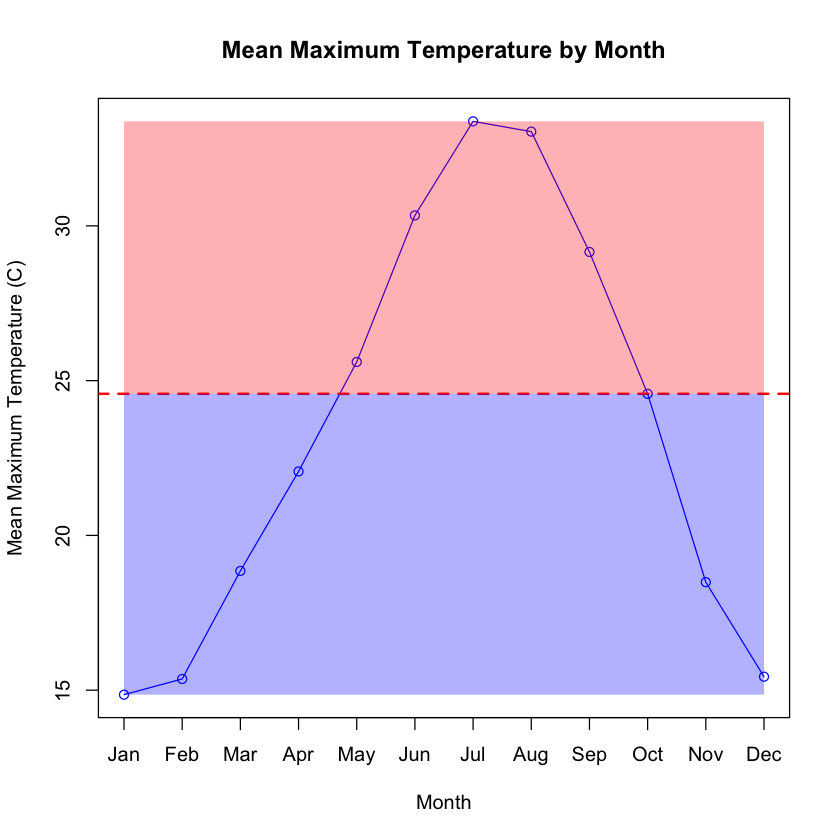

In [358]:
environment$date <- as.Date(environment$date)
environment$dow <- weekdays(environment$date)
environment$day <- format(environment$date, "%d")
environment$month <- format(environment$date, "%m")
environment$year <- format(environment$date, "%y")
environment$doy <- as.numeric(format(environment$date, "%j"))

# Calculate mean maximum temperature for each month
monthly_means <- tapply(environment$max_temp, environment$month, mean)

# Sort monthly means in ascending order
sorted_means <- sort(monthly_means)

# Define thresholds for summer and winter
summer_threshold <- sorted_means[7]  

# Plotting mean maximum temperature for each month
plot(1:12, monthly_means, type = "o", col = "blue", xlab = "Month", ylab = "Mean Maximum Temperature (C)", main = "Mean Maximum Temperature by Month", xaxt = "n")  # xaxt = "n" suppresses the x-axis labels

# Add custom x-axis labels with month names
axis(1, at = 1:12, labels = month.abb, tick = TRUE)

# Add horizontal lines to separate summer, winter, and middle
abline(h = summer_threshold, col = "red", lty = 2, lwd = 2)  # Summer threshold

# Shade the areas between the thresholds
polygon(c(1, 12, 12, 1), c(summer_threshold, summer_threshold, max(monthly_means), max(monthly_means)), col = adjustcolor("red", alpha.f = 0.3), border = NA)  # Summer area
polygon(c(1, 12, 12, 1), c(min(monthly_means), min(monthly_means), summer_threshold, summer_threshold), col = adjustcolor("blue", alpha.f = 0.3), border = NA)  # Winter area

# Function to categorize each month into a season
categorize_season <- function(month) {
  if (month %in% c("05", "06", "07", "08", "09", "10")) {
    return("Summer")
  } else {
    return("Winter")
  }
}

# Add a new column "season" to the environmentset based on the month
environment$season <- sapply(environment$month, categorize_season)


## DESCRIPTIVE STATS

In [359]:
#======== DESCRIPTIVE STATS ========
# Define a function to calculate summary statistics
summary_stats <- function(x) {
  mean_val <- mean(x, na.rm = TRUE)
  sd_val <- sd(x, na.rm = TRUE)
  min_val <- min(x, na.rm = TRUE)
  q25 <- quantile(x, 0.25, na.rm = TRUE)
  median_val <- median(x, na.rm = TRUE)
  q75 <- quantile(x, 0.75, na.rm = TRUE)
  max_val <- max(x, na.rm = TRUE)
  iqr_val <- IQR(x, na.rm = TRUE)
  
  result <- c(mean_val, sd_val, min_val, q25, median_val, q75, max_val, iqr_val)
  return(result)
}

#======== ENTIRE PERIOD ========
# Calculate summary statistics for the entire period
summary_data_all <- sapply(environment[, c("max_temp", "min_temp", "max_hum", "min_hum", "max_CO", "max_NO2", "max_NO", "max_PM10", "max_SO2", "max_O3")], summary_stats)
# Create a dataframe for the entire period
summary_df_all <- data.frame(
  Variable = c("Max Temperature", "Min Temperature", "Max Humidity", "Min Humidity", "Max CO", "Max NO2", "Max NO", "Max PM10", "Max SO2", "Max O3"),
  Mean = summary_data_all[1, ],
  SD = summary_data_all[2, ],
  Minimum = summary_data_all[3, ],
  Q25 = summary_data_all[4, ],
  Median = summary_data_all[5, ],
  Q75 = summary_data_all[6, ],
  Maximum = summary_data_all[7, ],
  IQR = summary_data_all[8, ],
  Period = "Entire Period",
  row.names = NULL
)

#======== WINTER ========
# Filter data for winter season
winter_data <- environment[environment$season == "Winter", ]
# Calculate summary statistics for winter season
summary_data_winter <- sapply(winter_data[, c("max_temp", "min_temp", "max_hum", "min_hum", "max_CO", "max_NO2", "max_NO", "max_PM10", "max_SO2", "max_O3")], summary_stats)
# Create a dataframe for winter season
summary_df_winter <- data.frame(
  Variable = c("Max Temperature", "Min Temperature", "Max Humidity", "Min Humidity", "Max CO", "Max NO2", "Max NO", "Max PM10", "Max SO2", "Max O3"),
  Mean = summary_data_winter[1, ],
  SD = summary_data_winter[2, ],
  Minimum = summary_data_winter[3, ],
  Q25 = summary_data_winter[4, ],
  Median = summary_data_winter[5, ],
  Q75 = summary_data_winter[6, ],
  Maximum = summary_data_winter[7, ],
  IQR = summary_data_winter[8, ],
  Period = "Winter Season",
  row.names = NULL
)

#======== SUMMER ========
# Filter data for summer season
summer_data <- environment[environment$season == "Summer", ]
# Calculate summary statistics for summer season
summary_data_summer <- sapply(summer_data[, c("max_temp", "min_temp", "max_hum", "min_hum", "max_CO", "max_NO2", "max_NO", "max_PM10", "max_SO2", "max_O3")], summary_stats)
# Create a dataframe for summer season
summary_df_summer <- data.frame(
  Variable = c("Max Temperature", "Min Temperature", "Max Humidity", "Min Humidity", "Max CO", "Max NO2", "Max NO", "Max PM10", "Max SO2", "Max O3"),
  Mean = summary_data_summer[1, ],
  SD = summary_data_summer[2, ],
  Minimum = summary_data_summer[3, ],
  Q25 = summary_data_summer[4, ],
  Median = summary_data_summer[5, ],
  Q75 = summary_data_summer[6, ],
  Maximum = summary_data_summer[7, ],
  IQR = summary_data_summer[8, ],
  Period = "Summer Season",
  row.names = NULL
)

# Combine all summary dataframes
summary_df <- rbind(summary_df_all, summary_df_winter, summary_df_summer)


#======== No OF DAYS ========
# Calculate the number of unique days for winter and summer seasons
num_unique_days_winter <- nrow(unique(winter_data["date"]))
num_unique_days_summer <- nrow(unique(summer_data["date"]))
# Create a dataframe for number of unique days
num_unique_days_df <- data.frame(
  Season = c("Winter", "Summer"),
  Num_Unique_Days = c(num_unique_days_winter, num_unique_days_summer),
  row.names = NULL
)

#======== FORMAT DECIMAL PLACES ========
# Function to round numerical values to two decimal places
round_2dec <- function(x) {
  round(x, digits = 2)
}

# Round the numerical values in the summary dataframe to two decimal places
summary_df[, c("Mean", "SD", "Minimum", "Q25", "Median", "Q75", "Maximum", "IQR")] <- 
  sapply(summary_df[, c("Mean", "SD", "Minimum", "Q25", "Median", "Q75", "Maximum", "IQR")], round_2dec)

#======== LATEX OUTPUT ========
# Create a LaTeX table
latex_table <- xtable(summary_df)
# Print the LaTeX table
#print(latex_table, include.rownames = FALSE)


# SMOOTHING

In [360]:
library(zoo)
library(ggplot2)
library(dplyr)

# Convert date to a Date object if it's not already in that format
environment$date <- as.Date(environment$date)

# Aggregate data by day and AT code
environment_daily <- environment %>%
  group_by(at_code, date) %>%
  summarise(events = sum(events), max_temp = mean(max_temp), max_hum = mean(max_hum), min_hum = mean(min_hum), min_temp = mean(min_temp), max_PM10 = mean(max_PM10), max_O3 = mean(max_O3), a_asir_90) %>%
  ungroup()

# Calculate the moving average
window_size <- 90  # Adjust the window size as needed
environment_daily <- environment_daily %>%
  group_by(at_code) %>%
  mutate(events_ma = rollapply(events, width = window_size, FUN = mean, align = "center", fill = NA),
        max_temp_ma = rollapply(max_temp, width = window_size, FUN = mean, align = "center", fill = NA),
        min_temp_ma = rollapply(min_temp, width = window_size, FUN = mean, align = "center", fill = NA),
        max_hum_ma = rollapply(max_hum, width = window_size, FUN = mean, align = "center", fill = NA),
        min_hum_ma = rollapply(min_hum, width = window_size, FUN = mean, align = "center", fill = NA),
        max_PM10_ma = rollapply(max_PM10, width = window_size, FUN = mean, align = "center", fill = NA),
        max_O3_ma = rollapply(max_O3, width = window_size, FUN = mean, align = "center", fill = NA))

`summarise()` has grouped output by 'at_code'. You can override using the
`.groups` argument.


Warning message:
"Removed 712 rows containing missing values or values outside the scale range
(`geom_line()`)."
Warning message:
"Removed 712 rows containing missing values or values outside the scale range
(`geom_line()`)."


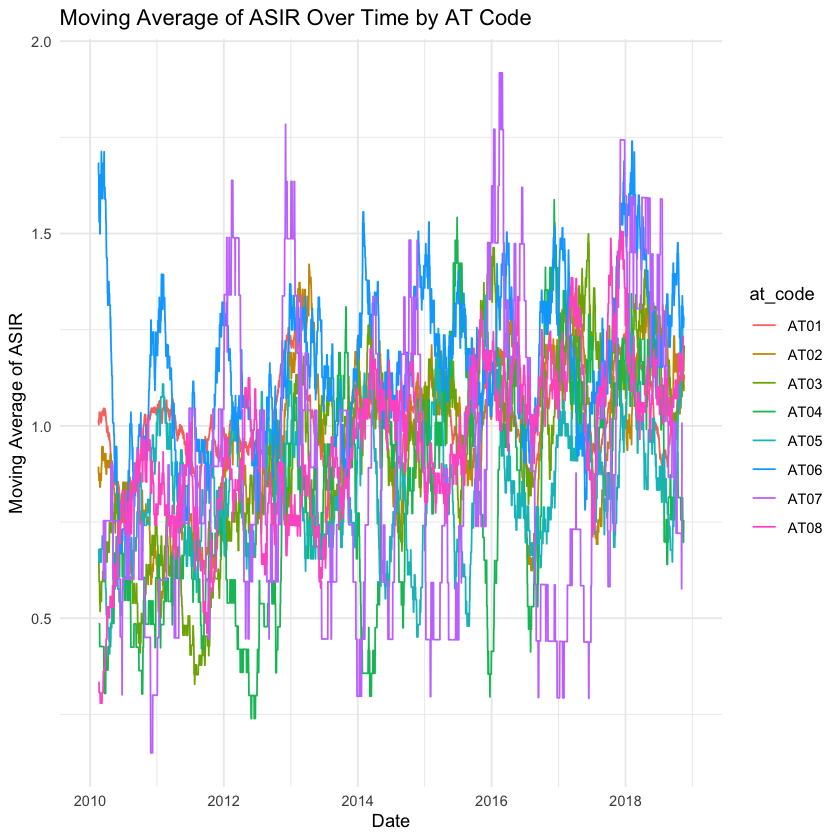

Warning message:
"Removed 6609 rows containing missing values or values outside the scale range
(`geom_line()`)."


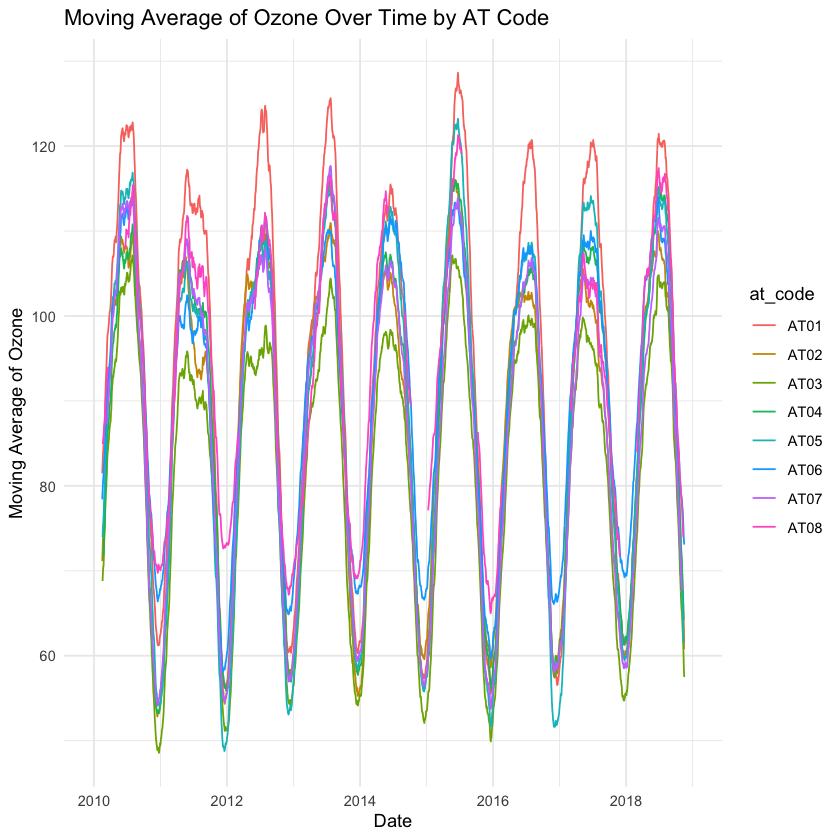

Warning message:
"Removed 712 rows containing missing values or values outside the scale range
(`geom_line()`)."


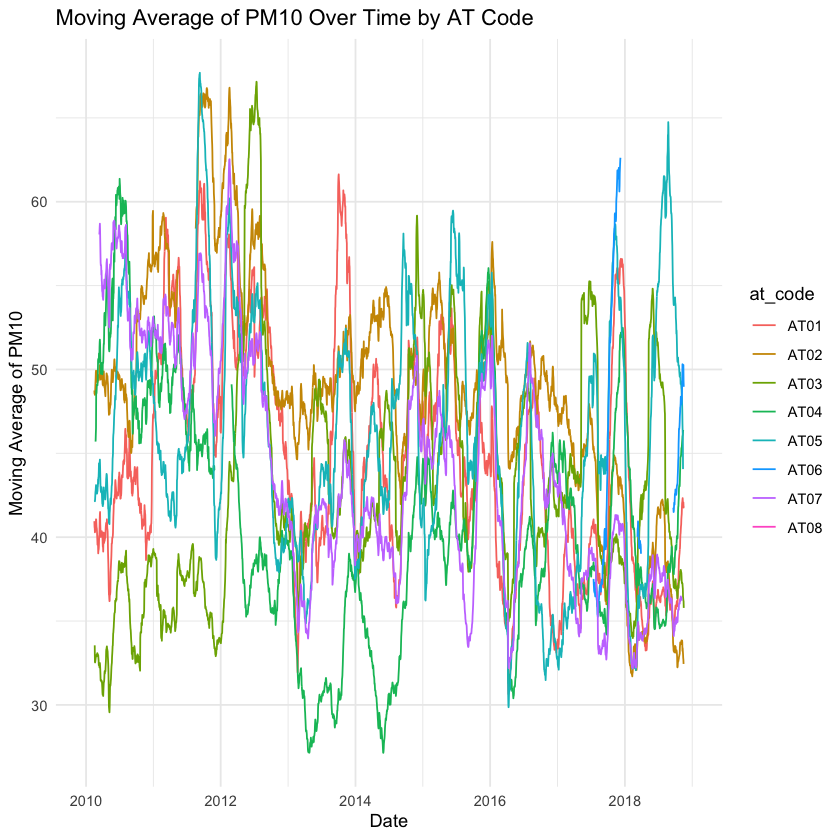

Warning message:
"Removed 712 rows containing missing values or values outside the scale range
(`geom_line()`)."


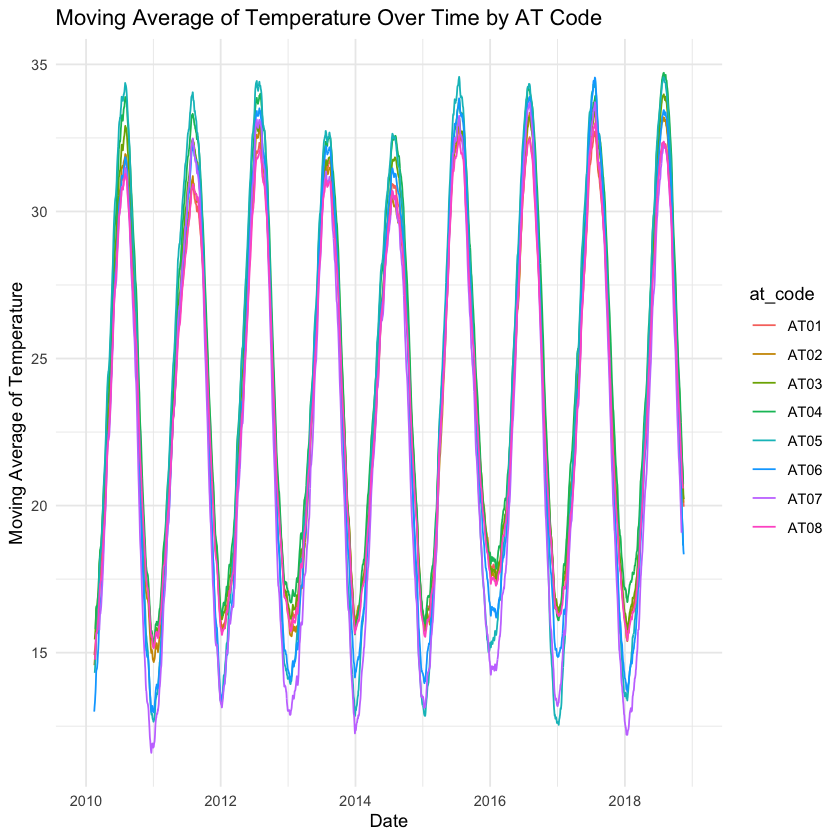

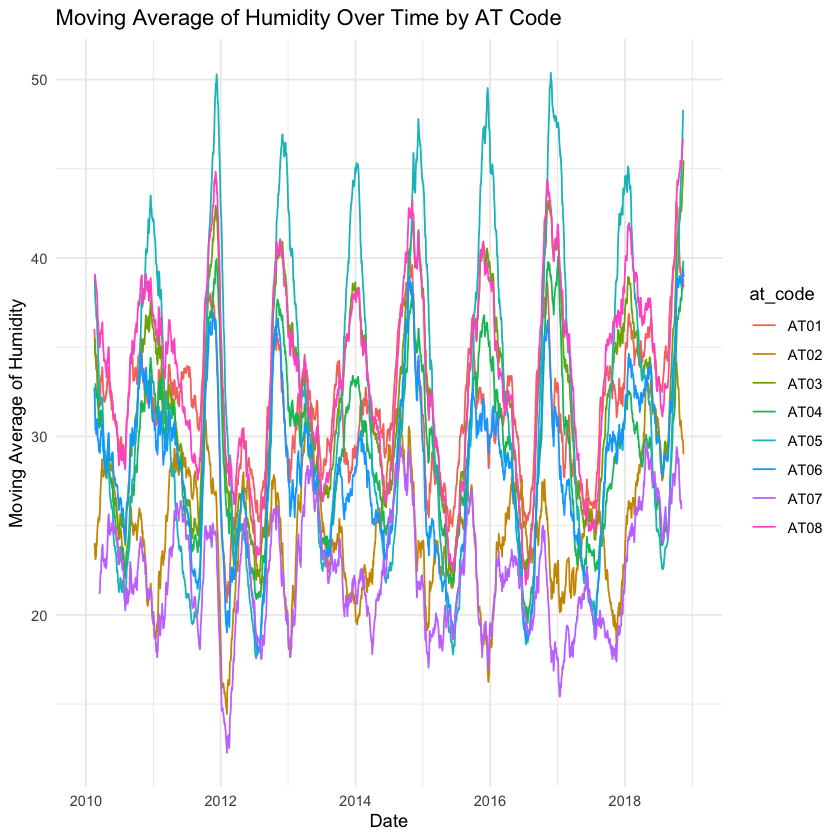

In [361]:

# Plotting Moving Averages

ggplot(environment_daily, aes(x = date, y = a_asir_90, group = at_code, color = at_code)) +
  geom_line() +
  labs(x = "Date", y = "Moving Average of ASIR", title = "Moving Average of ASIR Over Time by AT Code") +
  theme_minimal()

ggplot(environment_daily, aes(x = date, y = max_O3_ma, group = at_code, color = at_code)) +
  geom_line() +
  labs(x = "Date", y = "Moving Average of Ozone", title = "Moving Average of Ozone Over Time by AT Code") +
  theme_minimal()

ggplot(environment_daily, aes(x = date, y = max_PM10_ma, group = at_code, color = at_code)) +
  geom_line() +
  labs(x = "Date", y = "Moving Average of PM10", title = "Moving Average of PM10 Over Time by AT Code") +
  theme_minimal()

ggplot(environment_daily, aes(x = date, y = max_temp_ma, group = at_code, color = at_code)) +
geom_line() +
labs(x = "Date", y = "Moving Average of Temperature", title = "Moving Average of Temperature Over Time by AT Code") +
theme_minimal()

ggplot(environment_daily, aes(x = date, y = min_hum_ma, group = at_code, color = at_code)) +
geom_line() +
labs(x = "Date", y = "Moving Average of Humidity", title = "Moving Average of Humidity Over Time by AT Code") +
theme_minimal()

# TIME STRATIFIED MODEL

In [362]:
# Selecting the first two columns and the last five columns
environment_daily = environment_daily[, c(1, 2, 10, (ncol(environment_daily) - 5):ncol(environment_daily))]
colnames(environment_daily) <- c("at_code","date","a_asir_90","max_temp","min_temp","max_hum","min_hum","max_PM10","max_03")
environment_daily = data.frame(environment_daily %>% ungroup())

# Complete cases
environment_daily <- environment_daily[complete.cases(environment_daily), ]

environment_daily$date <- as.Date(environment_daily$date)
environment_daily$dow <- weekdays(environment_daily$date)
environment_daily$day <- format(environment_daily$date, "%d")
environment_daily$month <- format(environment_daily$date, "%m")
environment_daily$year <- format(environment_daily$date, "%y")
environment_daily$doy <- as.numeric(format(environment_daily$date, "%j"))

# Function to categorize each month into a season
categorize_season <- function(month) {
  if (month %in% c("05", "06", "07", "08", "09", "10")) {
    return("Summer")
  } else {
    return("Winter")
  }
}

# Add a new column "season" to the environment_dailyset based on the month
environment_daily$season <- sapply(environment_daily$month, categorize_season)

#======== Lags and CAs ========
# Function to create lags and cumulative averages
create_lags_and_cumulative_averages <- function(df, variable, max_lag = 5) {
  # Create lag variables
  for (lag in 0:max_lag) {
    lag_col <- paste(variable, "lag", lag, sep = "_")
    df <- df %>% mutate(!!lag_col := lag(!!sym(variable), lag))
  }
  
  # Create cumulative average variables
  for (n in 2:(max_lag + 1)) {
    lag_cols <- sapply(0:(n - 1), function(lag) paste(variable, "lag", lag, sep = "_"))
    ca_col <- paste(variable, "CA", n, sep = "_")
    df <- df %>% mutate(!!ca_col := rowMeans(select(., all_of(lag_cols)), na.rm = TRUE))
  }
  
  return(df)
}

# Calculate mean_temp and mean_hum
environment_daily <- environment_daily %>%
  mutate(
    mean_temp = (max_temp + min_temp) / 2,
    mean_hum = (max_hum + min_hum) / 2
  )

# List of variables for which to create lags and cumulative averages
variables <- c("max_temp", "min_temp", "max_hum", "min_hum", "mean_hum", "mean_temp", "max_PM10", "max_03")

# Initialize empty list to store processed dataframes
processed_data <- list()

# Loop through each at_code and apply the function to each variable
for (at_code in unique(environment_daily$at_code)) {
  df <- environment_daily[environment_daily$at_code == at_code, ]
  for (variable in variables) {
    df <- create_lags_and_cumulative_averages(df, variable)
  }

  # Generate splines for humidity adjustment.
  df$l03max_tmean = (df$max_temp_lag_0+df$max_temp_lag_1+df$max_temp_lag_2+df$max_temp_lag_3)/4
  df$l03min_tmean = (df$min_temp_lag_0+df$min_temp_lag_1+df$min_temp_lag_2+df$min_temp_lag_3)/4
  df$l03min_rh = (df$min_hum_lag_0+df$min_hum_lag_1+df$min_hum_lag_2+df$min_hum_lag_3)/4
  df$l03max_rh = (df$max_hum_lag_0+df$max_hum_lag_1+df$max_hum_lag_2+df$max_hum_lag_3)/4

  df$ns.max_tmean <- ns(df$l03max_tmean, df=6)
  df$ns.min_tmean <- ns(df$l03min_tmean, df=6)
  df$ns.min_rh <- ns(df$l03min_rh, df=5)
  df$ns.max_rh <- ns(df$l03max_rh, df=5)

  # Generate averaged lag exposure for PM10 sale for a 10 ug/m3 increase.
  df$l01pm10 <- (df$max_PM10_lag_0 + df$max_PM10_lag_1)/2
  df$l01pm10 <- df$l01pm10/10

  processed_data[[at_code]] <- df
}

# Merge the processed dataframes
data <- do.call(rbind, processed_data)

#======== Drop the first few values (because of the lags) ========
data <- data[!(data$date >= as.Date("2010-01-02") & data$date <= as.Date("2010-01-08")), ]

#======== Create different datasets for different seasons ========
data_entire = data
data_winter = data[data$season=="Winter",]
data_summer = data[data$season=="Summer",]

#======== Generate time-stratified strata ========
data_entire$month <- as.factor(data_entire$month)
data_entire$year  <- as.factor(data_entire$year)
data_entire$dow   <- as.factor(data_entire$dow)
data_entire$stratum <- with(data_entire, as.factor(year:month:dow))

data_entire$ind <- tapply(data_entire$a_asir_90, data_entire$stratum, sum)[data_entire$stratum]

# Fit fixed-effects conditional quasi-Poisson regression.
model.cc <- gnm(a_asir_90 ~ ns.max_tmean + ns.min_rh + l01pm10 + max_03_lag_0, 
                data=data_entire, family=quasipoisson, eliminate=stratum)

# Get Relative Risk for PM10.
Epi::ci.exp(model.cc, subset="l01pm10") 
summary(model.cc)


Warning message in ns(df$l03max_rh, df = 5):
"shoving 'interior' knots matching boundary knots to inside"


,exp(Est.),2.5%,97.5%
l01pm10,1.065059,1.059296,1.070853



Call:
gnm(formula = a_asir_90 ~ ns.max_tmean + ns.min_rh + l01pm10 + 
    max_03_lag_0, eliminate = stratum, family = quasipoisson, 
    data = data_entire)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.92392  -0.12953   0.01847   0.13176   0.63067  

Coefficients of interest:
                Estimate Std. Error t value Pr(>|t|)    
ns.max_tmean1 -0.0056540  0.0227552  -0.248  0.80377    
ns.max_tmean2 -0.0516833  0.0294906  -1.753  0.07970 .  
ns.max_tmean3 -0.1562973  0.0296413  -5.273 1.36e-07 ***
ns.max_tmean4 -0.2324501  0.0310604  -7.484 7.55e-14 ***
ns.max_tmean5 -0.2881514  0.0474530  -6.072 1.29e-09 ***
ns.max_tmean6 -0.3946690  0.0331807 -11.895  < 2e-16 ***
ns.min_rh1     0.0408491  0.0151096   2.704  0.00687 ** 
ns.min_rh2     0.0543678  0.0176200   3.086  0.00203 ** 
ns.min_rh3    -0.0161810  0.0133466  -1.212  0.22538    
ns.min_rh4     0.1576071  0.0343026   4.595 4.36e-06 ***
ns.min_rh5     0.2348607  0.0153437  15.307  < 2e-16 ***
l01pm10

In [365]:
# Fit fixed-effects conditional quasi-Poisson regression with different lags.
model.cc <- gnm(a_asir_90 ~ ns.max_tmean + ns.min_rh + l01pm10 + 
                max_temp_lag_1 +
                max_temp_lag_2 + max_temp_lag_3 + max_temp_lag_4 + max_temp_lag_5,
                data = data_entire, family = quasipoisson, eliminate = stratum)

# Get Relative Risk for PM10.
Epi::ci.exp(model.cc, subset = "l01pm10") 
summary(model.cc)


,exp(Est.),2.5%,97.5%
l01pm10,1.063841,1.058078,1.069635



Call:
gnm(formula = a_asir_90 ~ ns.max_tmean + ns.min_rh + l01pm10 + 
    max_03_lag_0 + max_temp_lag_1 + max_temp_lag_2 + max_temp_lag_3 + 
    max_temp_lag_4 + max_temp_lag_5, eliminate = stratum, family = quasipoisson, 
    data = data_entire)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.90496  -0.12787   0.01951   0.13263   0.62672  

Coefficients of interest:
                 Estimate Std. Error t value Pr(>|t|)    
ns.max_tmean1   0.0602836  0.0244453   2.466  0.01367 *  
ns.max_tmean2   0.0612204  0.0331683   1.846  0.06494 .  
ns.max_tmean3   0.0017112  0.0365301   0.047  0.96264    
ns.max_tmean4  -0.0391101  0.0405422  -0.965  0.33472    
ns.max_tmean5  -0.0264827  0.0587494  -0.451  0.65216    
ns.max_tmean6  -0.1772012  0.0443704  -3.994 6.53e-05 ***
ns.min_rh1      0.0269394  0.0152283   1.769  0.07690 .  
ns.min_rh2      0.0525316  0.0176139   2.982  0.00286 ** 
ns.min_rh3     -0.0315319  0.0134544  -2.344  0.01911 *  
ns.min_rh4      0.143

In [ ]:
# Compute confidence intervals for each subset and store the results
a <- Epi::ci.exp(model.cc, subset = "ns.min_rh1")
b <- Epi::ci.exp(model.cc, subset = "ns.min_rh2")
c <- Epi::ci.exp(model.cc, subset = "ns.min_rh3")
d <- Epi::ci.exp(model.cc, subset = "ns.min_rh4")
e <- Epi::ci.exp(model.cc, subset = "ns.min_rh5")

# Create a data frame to store the results
df <- data.frame(
  Subset = factor(1:5, labels = paste0("ns.min_rh", 1:5)),
  Lower = c(a[2], b[2], c[2], d[2], e[2]),
  Middle = c(a[1], b[1], c[1], d[1], e[1]),
  Upper = c(a[3], b[3], c[3], d[3], e[3])
)

# Plotting the results
ggplot(df, aes(x = Subset)) +
  geom_point(aes(y = Middle), color = "black") +
  geom_hline(yintercept = 1, linetype = "dashed", color = "blue") +  # Add horizontal line at y = 1
  geom_errorbar(aes(ymin = Lower, ymax = Upper), width = 0.2, color = "red") +
  labs(x = "Lags of Minimum Relative Humidity", y = "Relative Risk", 
       title = "Confidence Intervals for Different Lags of Minimum Relative Humidity") +
       scale_x_discrete(labels = c("ns.min_rh1" = "1", 
                              "ns.min_rh2" = "2", 
                              "ns.min_rh3" = "3", 
                              "ns.min_rh4" = "4", 
                              "ns.min_rh5" = "5")) +
  theme_minimal()
# Compute confidence intervals for each subset and store the results
a <- Epi::ci.exp(model.cc, subset = "ns.max_tmean1")
b <- Epi::ci.exp(model.cc, subset = "ns.max_tmean2")
c <- Epi::ci.exp(model.cc, subset = "ns.max_tmean3")
d <- Epi::ci.exp(model.cc, subset = "ns.max_tmean4")
e <- Epi::ci.exp(model.cc, subset = "ns.max_tmean5")

# Create a data frame to store the results
df <- data.frame(
  Subset = factor(1:5, labels = paste0("ns.max_tmean", 1:5)),
  Lower = c(a[2], b[2], c[2], d[2], e[2]),
  Middle = c(a[1], b[1], c[1], d[1], e[1]),
  Upper = c(a[3], b[3], c[3], d[3], e[3])
)

# Plotting the results
ggplot(df, aes(x = Subset)) +
  geom_point(aes(y = Middle), color = "black") +
  geom_hline(yintercept = 1, linetype = "dashed", color = "blue") +  # Add horizontal line at y = 1
  geom_errorbar(aes(ymin = Lower, ymax = Upper), width = 0.2, color = "red") +
  labs(x = "Lags of Maximum Temperature", y = "Relative Risk", 
       title = "Confidence Intervals for Different Lags of Maximum Temperature") +
       scale_x_discrete(labels = c("ns.max_tmean1" = "1", 
                              "ns.max_tmean2" = "2", 
                              "ns.max_tmean3" = "3", 
                              "ns.max_tmean4" = "4", 
                              "ns.max_tmean5" = "5")) +
  theme_minimal()

In [280]:
# Fit fixed-effects conditional quasi-Poisson regression.
#======== Generate time-stratified strata ========
data_winter$month <- as.factor(data_winter$month)
data_winter$year  <- as.factor(data_winter$year)
data_winter$dow   <- as.factor(data_winter$dow)
data_winter$stratum <- with(data_winter, as.factor(year:month:dow))

data_winter$ind <- tapply(data_winter$a_asir_90, data_winter$stratum, sum)[data_winter$stratum]

model.cc.temp <- gnm(a_asir_90 ~ max_temp + ns.min_rh, data=data_winter, family=quasipoisson, eliminate=stratum)

In [282]:
summary(model.cc.temp)


Call:
gnm(formula = a_asir_90 ~ max_temp + ns.min_rh, eliminate = stratum, 
    family = quasipoisson, data = data_winter)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.85996  -0.13203   0.02038   0.14492   0.59849  

Coefficients of interest:
            Estimate Std. Error t value Pr(>|t|)    
max_temp   -0.007002   0.001811  -3.865 0.000112 ***
ns.min_rh1 -0.099386   0.030504  -3.258 0.001126 ** 
ns.min_rh2 -0.140360   0.033794  -4.153 3.31e-05 ***
ns.min_rh3 -0.140296   0.022306  -6.290 3.33e-10 ***
ns.min_rh4 -0.374408   0.067588  -5.540 3.12e-08 ***
ns.min_rh5  0.039378   0.022927   1.717 0.085926 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for quasipoisson family taken to be 0.05445697)

Residual deviance: 516.22 on 8777 degrees of freedom
AIC: NA

Number of iterations: 2


In [259]:
summary(model.cc)


Call:
gnm(formula = a_asir_90 ~ ns.max_tmean + ns.min_rh + l01pm10, 
    eliminate = stratum, family = quasipoisson, data = data_entire)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.91869  -0.12972   0.01852   0.13357   0.63002  

Coefficients of interest:
               Estimate Std. Error t value Pr(>|t|)    
ns.max_tmean1  0.028447   0.022486   1.265 0.205856    
ns.max_tmean2  0.008242   0.028752   0.287 0.774393    
ns.max_tmean3 -0.073398   0.028144  -2.608 0.009117 ** 
ns.max_tmean4 -0.133419   0.028963  -4.607 4.12e-06 ***
ns.max_tmean5 -0.165490   0.045436  -3.642 0.000271 ***
ns.max_tmean6 -0.282739   0.030644  -9.227  < 2e-16 ***
ns.min_rh1     0.048144   0.015090   3.190 0.001423 ** 
ns.min_rh2     0.066234   0.017583   3.767 0.000166 ***
ns.min_rh3    -0.017335   0.013360  -1.297 0.194485    
ns.min_rh4     0.172343   0.034297   5.025 5.08e-07 ***
ns.min_rh5     0.240576   0.015352  15.671  < 2e-16 ***
l01pm10        0.064770   0.002764  23.

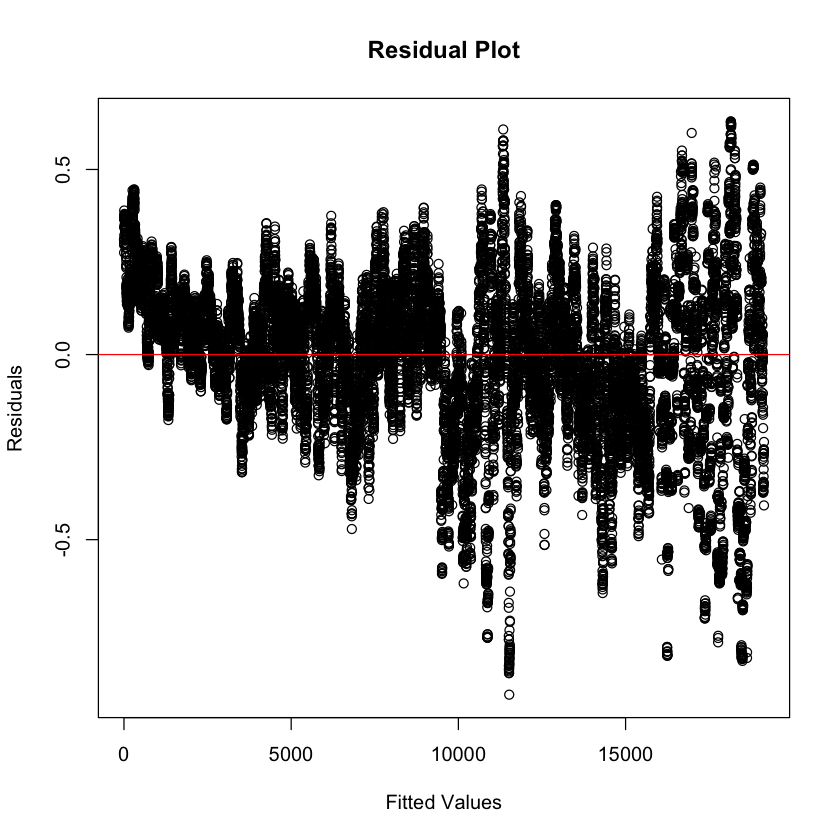

In [260]:
# Residuals of the model to check for patterns.
residuals <- residuals(model.cc, type = "deviance")
plot(residuals, ylab = "Residuals", xlab = "Fitted Values", main = "Residual Plot")
abline(h = 0, col = "red")

In [261]:
#======== Stratified analysis for AT01 and AT03 ========
dat.2city <- data_entire[data_entire$at_code %in% c("AT01","AT03"),]

# Generate space-time-stratified strata.
dat.2city$at_code  <- as.factor(dat.2city$at_code)
dat.2city$month <- as.factor(dat.2city$month)
dat.2city$year  <- as.factor(dat.2city$year)
dat.2city$dow   <- as.factor(dat.2city$dow)
dat.2city$stratum <- with(dat.2city, as.factor(at_code:year:month:dow))
dat.2city$ind <- tapply(dat.2city$a_asir_90, dat.2city$stratum, sum)[dat.2city$stratum]

# Fit conditional Poisson with space-time-stratified strata.
model.cc.adj.city <- gnm(a_asir_90 ~ ns.max_tmean + ns.min_rh + l01pm10, 
                         data=dat.2city, family=quasipoisson, subset=ind>0, eliminate=stratum)
Epi::ci.exp(model.cc.adj.city, subset="l01pm10") 
summary(model.cc.adj.city)


,exp(Est.),2.5%,97.5%
l01pm10,1.028655,1.020754,1.036617



Call:
gnm(formula = a_asir_90 ~ ns.max_tmean + ns.min_rh + l01pm10, 
    eliminate = stratum, family = quasipoisson, data = dat.2city, 
    subset = ind > 0)

Deviance Residuals: 
       Min          1Q      Median          3Q         Max  
-0.2220676  -0.0181375  -0.0002999   0.0180467   0.1909762  

Coefficients of interest:
               Estimate Std. Error t value Pr(>|t|)    
ns.max_tmean1 -0.079326   0.009974  -7.953  < 2e-16 ***
ns.max_tmean2 -0.069171   0.012407  -5.575 2.60e-08 ***
ns.max_tmean3 -0.162047   0.012007 -13.496  < 2e-16 ***
ns.max_tmean4 -0.157819   0.011978 -13.176  < 2e-16 ***
ns.max_tmean5 -0.287515   0.020859 -13.784  < 2e-16 ***
ns.max_tmean6 -0.266921   0.013373 -19.960  < 2e-16 ***
ns.min_rh1    -0.012225   0.013914  -0.879 0.379650    
ns.min_rh2    -0.011655   0.014961  -0.779 0.436012    
ns.min_rh3    -0.043639   0.013125  -3.325 0.000891 ***
ns.min_rh4    -0.028598   0.028333  -1.009 0.312859    
ns.min_rh5    -0.117899   0.017402  -6.775 1.39e-11 **

In [ ]:
# Stratified analysis by city.
model.cc.vlc <- gnm(a_asir_90 ~ ns.max_tmean + ns.min_rh + l01pm10, 
                    data=subset(dat.2city,at_code=="AT01"), 
                    family=quasipoisson, subset=ind>0, eliminate=stratum)
Epi::ci.exp(model.cc.vlc, subset="l01pm10") 

model.cc.ldn <- gnm(a_asir_90 ~ ns.max_tmean + ns.min_rh + l01pm10, 
                    data=subset(dat.2city,at_code=="AT03"), 
                    family=quasipoisson, subset=ind>0, eliminate=stratum)
Epi::ci.exp(model.cc.ldn, subset="l01pm10") 

# Interaction analysis by location.
model.cc.city.int <- gnm(a_asir_90 ~ ns.max_tmean + ns.min_rh + at_code + l01pm10:at_code, 
                        data=dat.2city, family=quasipoisson, subset=ind>0, eliminate=stratum)
Epi::ci.exp(model.cc.city.int, subset="l01pm10") 

# Likelihood ratio test for effect modification.
anova(model.cc.adj.city, model.cc.city.int, test="LRT")